In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np

from sklearn.preprocessing import Imputer

In [90]:
def load_data(batch_size, shuffle, use_val=False):
    train = pd.read_csv('../data/train.csv', header=0, index_col=0).values
    test = pd.read_csv('../data/test.csv', header=0, index_col=0).values
        
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    X_train = imp.fit_transform(train[:, 1:])
    y_train = train[:, 0]
    X_test = imp.transform(test[:, 1:])
    
    print(X_train.shape, y_train.shape)
    
    n_train = int(len(X_train) * 0.9)
    train_dataset = TensorDataset(
        torch.from_numpy(X_train[:n_train]).float(), 
        torch.from_numpy(y_train[:n_train]).float())
    if use_val:
        val_dataset = TensorDataset(
            torch.from_numpy(X_train[n_train:]).float(), 
            torch.from_numpy(y_train[n_train:]).float())
    test_dataset = TensorDataset(
        torch.from_numpy(X_test).float(), 
        torch.from_numpy(np.zeros(len(X_test))).float())
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle)
    if use_val:
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(
        test_dataset, batch_size=1, shuffle=False)

    return X_train.shape[1], train_loader, val_loader if use_val else None, test_loader

In [96]:
n_features, train_loader, val_loader, test_loader = load_data(batch_size=256, shuffle=True, use_val=True)

(150000, 10) (150000,)


In [97]:
in_dim = n_features
h_dim = 30
out_dim = 1

model = nn.Sequential(
    nn.Linear(in_dim, h_dim),
    nn.ReLU(),
    nn.Linear(h_dim, out_dim),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [98]:
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels.float())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0


[1,   500] loss: 1.825
[2,   500] loss: 1.103
[3,   500] loss: 0.448
[4,   500] loss: 0.432
[5,   500] loss: 0.411
[6,   500] loss: 0.377
[7,   500] loss: 0.351
[8,   500] loss: 0.346
[9,   500] loss: 0.329
[10,   500] loss: 0.298
[11,   500] loss: 0.284
[12,   500] loss: 0.277
[13,   500] loss: 0.253
[14,   500] loss: 0.266
[15,   500] loss: 0.250
[16,   500] loss: 0.249
[17,   500] loss: 0.252
[18,   500] loss: 0.245
[19,   500] loss: 0.259
[20,   500] loss: 0.255
[21,   500] loss: 0.247
[22,   500] loss: 0.244
[23,   500] loss: 0.259
[24,   500] loss: 0.244
[25,   500] loss: 0.254
[26,   500] loss: 0.248
[27,   500] loss: 0.247
[28,   500] loss: 0.245
[29,   500] loss: 0.261
[30,   500] loss: 0.258


In [122]:
correct = 0
total = 0
pred_ages = []
all_ages = []

for data in train_loader:
    inputs, labels = data
    inputs, labels = Variable(inputs), Variable(labels)
    
    outputs = model(inputs).squeeze()
    predicted = torch.round(outputs.data).long()
    msk = torch.eq(predicted, 1)
    ages = list((inputs[:, 1][msk]).data.numpy())
    _ages = list((inputs[:, 1]).data.numpy())
    pred_ages.extend(ages)
    all_ages.extend(_ages)
#     total += labels.size(0)
#     correct += (predicted.long() == labels.long()).sum().data[0]

# print('Accuracy of the network on the val set: ', correct / total)

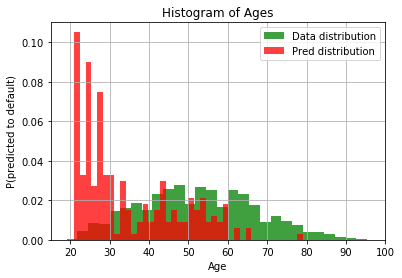

In [127]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# the histogram of the data
n, bins, patches = plt.hist(all_ages, 40, normed=1, facecolor='green', alpha=0.75, label='Data distribution')
n, bins, patches = plt.hist(pred_ages, 40, normed=1, facecolor='red', alpha=0.75, label='Pred distribution')

plt.xlabel('Age')
plt.ylabel('P(predicted to default)')
plt.title('Histogram of Ages')
plt.grid(True)
plt.axis([15, 100, 0, 0.11])
plt.legend()
plt.show()

In [95]:
with open('../results/preds.txt', "w") as fout:
    print("Id,Probability", file=fout)
    for i, data in enumerate(test_loader, start=1):
        input, _ = data
        input = Variable(input)

        output = model(input).squeeze()
        print("%d,%f"%(i, output), file=fout)